# Notebook for model creation

<b> Generative process </b>

>1. For each season $m \in \{1,\ldots, M\}$
>>    a) Draw $\boldsymbol{\theta}_{f,m} \sim \mathcal{N}(\boldsymbol{\theta}_f|\mathbf{0}, \lambda_f\mathbf{I})$ <br>
>>    b) Draw $\boldsymbol{\theta}_{g,m} \sim \mathcal{N}(\boldsymbol{\theta}_g|\mathbf{0}, \lambda_g\mathbf{I})$<br>
>>    c) Draw $\mathbf{R}_m \sim \mathcal{N}(\mathbf{R} | \mathbf{0}, \gamma\mathbf{I})$<br>
>>    d) Draw $\sigma \sim \mathcal{I}\mathcal{G}(\sigma|\tau)$<br>
>>    e) Draw $\beta_m \sim \mathcal{N}(\beta_m|\mathbf{0}, \sigma_\beta^2\mathbf{I})$<br>
>2. For each time $t \in \{1,\ldots, T\}$ <br>
>>   a) Draw season variable $z_t \sim \text{Multinomial}(z_t | \text{Softmax}(X_t^W, \beta_1,\ldots, \beta_M))$<br>
>>    b) Draw hidden state for season $z_t$ $\mathbf{h_t^{z_t}} \sim \mathcal{N}(\mathbf{h_t^{z_t}}| f\left(\mathbf{h_{t-1}^{z_{t-1}}}, \mathbf{X_t}, \boldsymbol{\theta}_{f,z_t}\right), \mathbf{R}_m)$<br>
>>    c) Draw price $y_t \sim \mathcal{N}(y_t|g(\mathbf{h_t^{z_t}}, \boldsymbol{\theta}_{f,z_t}), \sigma^2)$<br>


<b> PGM </b>

![](pgm.png)

## Imports

In [1]:
import os
import pyro
import pyro.distributions as dist
import torch
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def get_data():
    # all data
    df = pd.read_csv("preprocessed_data/df.csv") 
    X = df

    # weather data
    dfW = df[['temp', 'temp','temp_min','temp_max','pressure','humidity','wind_speed','wind_deg','rain_1h','rain_3h','snow_3h']].copy()

    # Set outliers to mean
    #dfW["pressure"] = dfW["pressure"].apply(lambda p: dfW["pressure"].mean() if )
    dfW.loc[(df["pressure"] > 1e4) | (df["pressure"] < 1e2), "pressure"] = df["pressure"].mean()

    # Normalize stuff
    dfW['temp'] = (dfW['temp'] - 273.15) / 50
    dfW['temp_min'] = (dfW['temp_min'] - 273.15) / 50
    dfW['temp_max'] = (dfW['temp_max'] - 273.15) / 50
    dfW['pressure'] = (dfW["pressure"] - 1013) / 1e3
    dfW['humidity'] = dfW["humidity"] / 100
    dfW['wind_speed'] = dfW["wind_speed"] / 50
    dfW['wind_deg'] = dfW["wind_deg"] / 360
    dfW['rain_1h'] = dfW["rain_1h"] / 1e3
    dfW['rain_3h'] = dfW["rain_3h"] / 1e3
    dfW['snow_3h'] = dfW["snow_3h"] / 1e3

    X_W = dfW.values

    # energy data
    dfE = df[['generation biomass', 'generation fossil',
       'generation hydro', 'generation nuclear', 'generation other',
       'generation other renewable', 'generation solar', 'generation total',
       'generation waste', 'generation wind onshore']]

    X_E = dfE.values

    # price
    y = df['price actual'].values


    return X_W, X_E, y

X_W, X_E, y = get_data()

X_W.shape, X_E.shape, y.shape



((178181, 11), (178181, 10), (178181,))

In [3]:
np.concatenate((X_W, X_E), axis=1).shape

(178181, 21)

## Model

In [4]:
class F(torch.nn.Module):
    def __init__(self, n_in, n_hidden, n_out):
        super(F, self).__init__()
        
        # Architecture
        self.in_layer = torch.nn.Linear(n_in, n_hidden)
        self.h_layer = torch.nn.Linear(n_hidden, n_hidden)
        self.out_layer = torch.nn.Linear(n_hidden, n_out)
        
        # Activation functions
        self.tanh = torch.nn.Tanh()
        
    def forward(self, X):
        # Forward pass
        X = self.tanh(self.in_layer(X))
        X = self.tanh(self.h_layer(X))
        X = self.out_layer(X)
        
        return X

# F = torch.nn.LSTM()

class G(torch.nn.Module):
    def __init__(self, n_in, n_hidden, n_out):
        super(G, self).__init__()
        
        # Architecture
        self.in_layer = torch.nn.Linear(n_in, n_hidden)
        self.h_layer = torch.nn.Linear(n_hidden, n_hidden)
        self.out_layer = torch.nn.Linear(n_hidden, n_out)
        
        # Activation functions
        self.tanh = torch.nn.Tanh()
        
    def forward(self, X):
        # Forward pass
        X = self.tanh(self.in_layer(X))
        X = self.tanh(self.h_layer(X))
        X = self.out_layer(X)
        
        return X

def init_nnet(n_f_features, n_g_features, h_dim=10, lambda_f = 1, lambda_g = 1):
  # Initialize the neural network from PyTorch 
  f_torch = F(n_in=n_f_features, n_hidden=4, n_out=h_dim)
  # f_torch = torch.nn.LSTM(input_size = n_f_features, hidden_size = h_dim, num_layers = 4)
  g_torch = G(n_in=n_g_features, n_hidden=4, n_out=1) 
  
  # Convert the PyTorch neural net into a Pyro model with priors
  f_priors = {} # Priors for the neural model
  for name, par in f_torch.named_parameters():     # Loop over all neural network parameters
      f_priors[name] = dist.Normal(torch.zeros(*par.shape), lambda_f*torch.ones(*par.shape)).to_event()#.independent(1) # Each parameter has a N(0, 1) prior

  g_priors = {} # Priors for the neural model
  for name, par in g_torch.named_parameters():     # Loop over all neural network parameters
      g_priors[name] = dist.Normal(torch.zeros(*par.shape), lambda_g*torch.ones(*par.shape)).to_event()#.independent(1) # Each parameter has a N(0, 1) prior
  
  # Make this model and these priors a Pyro model
  f_bayesian = pyro.random_module('f_bayesian_model', f_torch, f_priors)
  g_bayesian = pyro.random_module('g_bayesian_model', g_torch, g_priors)

  # Initialize the models 
  f = f_bayesian()     
  g = g_bayesian() 

  return f, g

def model(X_W, X_E, obs=None,
  lambda_f = 1, # variance of theta_f
  lambda_g = 1, # variance of theta_g
  gamma = 1, # variance of R
  tau = 1, 
  sigma_beta = 1, # variance of beta
  M = 1, # number of seasons
  T = 1, # number of time steps
  h_dim = 10, # number of hidden states
  ):
    
    # with pyro.plate("season", M):
    # concatenate weather and energy features
    X = np.concatenate((X_W, X_E), axis=1)

    # get number of features
    n_weather_features = X_W.shape[1]
    n_features = X.shape[1]

    

    # initialize the parameters
    f, g = init_nnet(n_features, n_weather_features, h_dim=h_dim, lambda_f = lambda_f, lambda_g = lambda_g) # neural networks f and g
    R = pyro.sample("R", dist.HalfCauchy(gamma*torch.ones(h_dim))) # covariance matrix
    # R = torch.diag(R)
    sigma = pyro.sample("sigma", dist.HalfCauchy(tau))

    # with pyro.plate("features", n_weather_features):
    # beta = pyro.sample("beta", dist.Normal(torch.zeros(n_weather_features), sigma_beta*torch.ones(n_weather_features)))

    # h_prev = pyro.sample("h0", dist.Normal(torch.zeros(h_dim), torch.ones(h_dim)))
    # h_prev, c_prev = torch.zeros
    with pyro.plate("time", T) as t:
      # Draw season variable zt ∼ Multinomial(zt |Softmax(XtW , β1 , . . . , βM ))
      # z = pyro.sample("z", dist.Categorical(logits=X_W_t @ beta))
      # if t == 0:
      #   f_out, (h_prev, c_prev) = f(torch.tensor(X[t]).float().unsqueeze(0))
      # else:
      #   f_out, (h_prev, c_prev) = f(torch.from_numpy(X[t]), (h_prev, c_prev))
      xt = torch.tensor(X[t]).float()#.unsqueeze(0)
      f_out = f(xt).squeeze(-1)
      print(f_out.shape, R.shape, t)
      h = pyro.sample("h", dist.Normal(f_out, R))

      print(h.shape, f_out.shape, xt.shape)

      g_out = g(h).squeeze(-1)
      y = pyro.sample("obs", dist.Normal(g_out, sigma), obs=y)
      print(y)

    return y

model(X_W, X_E)


torch.Size([10]) torch.Size([10]) tensor([0])


/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/site-packages/pyro/primitives.py:491: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  warnings.warn(


ValueError: Shape mismatch inside plate('time') at site h dim -1, 1 vs 10

## Inspect seasonality

c:\Users\lukas\Git\Studie\42186-MBML-Project\MBML-env\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


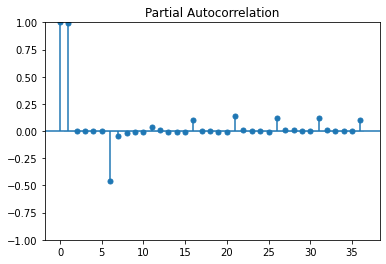

In [7]:
# !python -m pip install statsmodels
from statsmodels.graphics import tsaplots
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("preprocessed_data/df.csv") 
y = df['price actual'].values

# fig, ax = plt.subplots(1, 2, figsize=(12, 8))
tsaplots.plot_pacf(y, lags=36, alpha = .05)
plt.show()